In [1]:
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
from torch import optim
import time
import copy
import math
from torch.optim.lr_scheduler import StepLR

seedy = 666
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

trainset = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='data/', train=False, download=True, transform=transform_test)

torch.manual_seed(seedy)
val_size = 5000
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])

print(len(train_ds), len(val_ds))

Files already downloaded and verified
Files already downloaded and verified
45000 5000


In [29]:
def eval_model(model, loader, thresh=0.5):
    model.eval()
    for inputs, labels in loader:
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        outputs = model(inputs)
        y_test = np.asarray(labels.cpu())
        y_score = outputs.cpu().detach().numpy()
        y_pred = np.argmax(y_score,axis=1)
        acc = accuracy_score(y_test,y_pred)    
        return y_test, y_score, acc

In [30]:
def train_model(train_loader, val_loader, model, optimizer, batch_size, num_epochs, stopper='loss'):
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    all_grads = []
    
    running = - math.inf
    current = running
    
    best_run = 0
    best_model = copy.deepcopy(model.state_dict())
    
    for epoch in tqdm_notebook(range(num_epochs), total=num_epochs):
        print("Epoch",epoch+1)
        for phase in ['train','validate']:
            running_loss = 0.0
            running_acc = 0.0
            
            if phase=='train':
                loader = train_loader
                model.train()
            else:
                loader = val_loader
                model.eval()
                
            for i,(inputs,labels) in enumerate(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()                        
                        optimizer.step()
                running_loss += loss.item()
                
                # # # # # # # # # # # # # # # # # # # # #
#                 if i%10==0:
#                     grads = []
#                     for param in model.parameters():
#                         grads.append(param.grad.view(-1))
#                     grads = torch.cat(grads)
#                     grads = grads.cpu().detach().numpy() 
#                     all_grads.append(grads)
                # # # # # # # # # # # # # # # # # # # # #

                y_test = np.asarray(labels.cpu())
                y_score = outputs.cpu().detach().numpy()
                y_pred = np.argmax(y_score,axis=1)
                acc = accuracy_score(y_test,y_pred)
                running_acc += acc
            
            loss = running_loss / len(loader) 
            acc =  running_acc / len(loader) 
            
            if phase=='train':
                train_loss.append(loss)
                train_acc.append(acc)
            elif phase=='validate':
                val_loss.append(loss)
                val_acc.append(acc)
                if stopper=='loss':
                    current = -loss
                elif stopper=='acc':
                    current = acc
                if current >= running:
                    running = current
                    best_run = epoch+1
                    best_model = copy.deepcopy(model.state_dict()) 
                
            print("~ %s LOSS: %5.3f | ACC: %5.3f" % (phase,loss,acc))
            if current >= running and phase=='validate':
                print("      BEST SO FAR ^ ^ ^")
        
    return (best_run, best_model, train_loss, train_acc, val_loss, val_acc, all_grads)

In [119]:
class Residual_oneLayer(nn.Module): 
    def __init__(self, input_channels, num_channels, use_1x1conv=True):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, num_channels,kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv2 = nn.Conv2d(input_channels, num_channels, kernel_size=1)
        else:
            self.conv2 = None
            
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        if self.conv2:
            X = self.conv2(X)
        Y += X
        return F.relu(Y)   
    
class Residual_twoLayers(nn.Module): 
    def __init__(self, input_channels, num_channels, use_1x1conv=True, double=False):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, num_channels,kernel_size=3, padding=1)
        
        if double:
            self.out_chan = num_channels*2
        else:
            self.out_chan = num_channels

        self.conv2 = nn.Conv2d(num_channels, self.out_chan, kernel_size=3, padding=1)
            
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, self.out_chan, kernel_size=1)
        else:
            self.conv2 = None
            
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(self.out_chan)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


class CNN_3res_2convPerBlock(nn.Module):

    def __init__(self, drpt=0.05):
        super(CNN_3res_2convPerBlock, self).__init__()


        self.conv_1 = nn.Sequential( Residual_twoLayers(3, 32, True, True), 
                                     nn.MaxPool2d(kernel_size=2, stride=2) )
        
        self.conv_2 = nn.Sequential( Residual_twoLayers(64, 128, True, False), 
                                     nn.MaxPool2d(kernel_size=2, stride=2),
                                     nn.Dropout2d(p=drpt))

        self.conv_3 = nn.Sequential( Residual_twoLayers(128, 256, True, False), 
                                     nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=drpt*2),
            nn.Linear(4096, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=drpt*2),
            nn.Linear(512, 10) )

    def forward(self, x):
        x = self.conv_1(x)        
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x
    
    
class CNN_6res_1convPerBlock(nn.Module):

    def __init__(self, drpt=0.05):
        super(CNN_6res_1convPerBlock, self).__init__()

#         self.conv_11 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(inplace=True) )  
        self.conv_11 = Residual_oneLayer(3, 32)  
                
#         self.conv_12 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#             nn.LeakyReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2) )
        self.conv_12 = nn.Sequential( Residual_oneLayer(32, 64), nn.MaxPool2d(kernel_size=2, stride=2) )

#         self.conv_21 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(inplace=True) )
        self.conv_21 = Residual_oneLayer(64, 128)  
        
#         self.conv_22 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
#             nn.LeakyReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout2d(p=drpt) )
        self.conv_22 = nn.Sequential( Residual_oneLayer(128, 128), 
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.Dropout2d(p=drpt)) 

#         self.conv_31 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(inplace=True)
        self.conv_31 = Residual_oneLayer(128, 256)  

#         self.conv_32 = nn.Sequential(
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#             nn.LeakyReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2) )
        self.conv_32 = nn.Sequential( Residual_oneLayer(256, 256), nn.MaxPool2d(kernel_size=2, stride=2) )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=drpt*2),
            nn.Linear(4096, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=drpt*2),
            nn.Linear(512, 10) )

    def forward(self, x):
        x = self.conv_11(x)
        x = self.conv_12(x)
        x = self.conv_21(x)
        x = self.conv_22(x)
        x = self.conv_31(x)
        x = self.conv_32(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

# 2. Residual connections (2 points)

Please make use of the model code from Homework 4 question 2 as you work on this question.

If your model didn't use residual connections, add them. If it already had residual connections, remove them. How does the performance change? Please experiment with applying residual connections around different blocks, where a block is a subset of layers (for example, add a residual connection around a single convolution/nonlinearity combination, or a residual connection around two convolution/nonlinearity combinations). Note that you may need to add 1x1 convolutions in the residual path if your block changes the shape (spatial or number of channels) of the input.

In [120]:
s = time.time()

my_stopper = 'acc'
my_batch = 256 #128
my_lr = 0.0005
drpt = 0.075
# # # # # # # # # # # # #
my_epochs = 30

train_loader = DataLoader(train_ds, my_batch, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, my_batch*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, my_batch*2, num_workers=4, pin_memory=True)

model = CNN_6res_1convPerBlock(drpt).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=my_lr)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

(best_run, best_model, train_losses, train_accs, val_losses, val_accs, all_grads) = \
                train_model(train_loader, val_loader,
                            model, optimizer,my_batch, 
                            my_epochs,my_stopper)

print("%5.3f mins" % ((time.time()-s)/60))

Epoch 1
~ train LOSS: 1.487 | ACC: 0.447
~ validate LOSS: 1.203 | ACC: 0.568
      BEST SO FAR ^ ^ ^
Epoch 2
~ train LOSS: 0.999 | ACC: 0.644
~ validate LOSS: 1.017 | ACC: 0.645
      BEST SO FAR ^ ^ ^
Epoch 3
~ train LOSS: 0.796 | ACC: 0.719
~ validate LOSS: 0.806 | ACC: 0.716
      BEST SO FAR ^ ^ ^
Epoch 4
~ train LOSS: 0.667 | ACC: 0.764
~ validate LOSS: 0.712 | ACC: 0.754
      BEST SO FAR ^ ^ ^
Epoch 5
~ train LOSS: 0.590 | ACC: 0.795
~ validate LOSS: 0.608 | ACC: 0.782
      BEST SO FAR ^ ^ ^
Epoch 6
~ train LOSS: 0.529 | ACC: 0.816
~ validate LOSS: 0.586 | ACC: 0.802
      BEST SO FAR ^ ^ ^
Epoch 7
~ train LOSS: 0.482 | ACC: 0.832
~ validate LOSS: 0.611 | ACC: 0.792
Epoch 8
~ train LOSS: 0.440 | ACC: 0.848
~ validate LOSS: 0.508 | ACC: 0.826
      BEST SO FAR ^ ^ ^
Epoch 9
~ train LOSS: 0.415 | ACC: 0.856
~ validate LOSS: 0.507 | ACC: 0.825
Epoch 10
~ train LOSS: 0.381 | ACC: 0.868
~ validate LOSS: 0.458 | ACC: 0.844
      BEST SO FAR ^ ^ ^
Epoch 11
~ train LOSS: 0.347 | ACC: 0

In [121]:
# print(len(all_grads))
# grads_np = np.asarray([x for x in all_grads])
# ## Square the gradients.
# grads_sqd = np.square(grads_np)
# ## Sum the gradients across params for each epoch.
# grads_sumd = np.sum(grads_sqd,axis=1) 

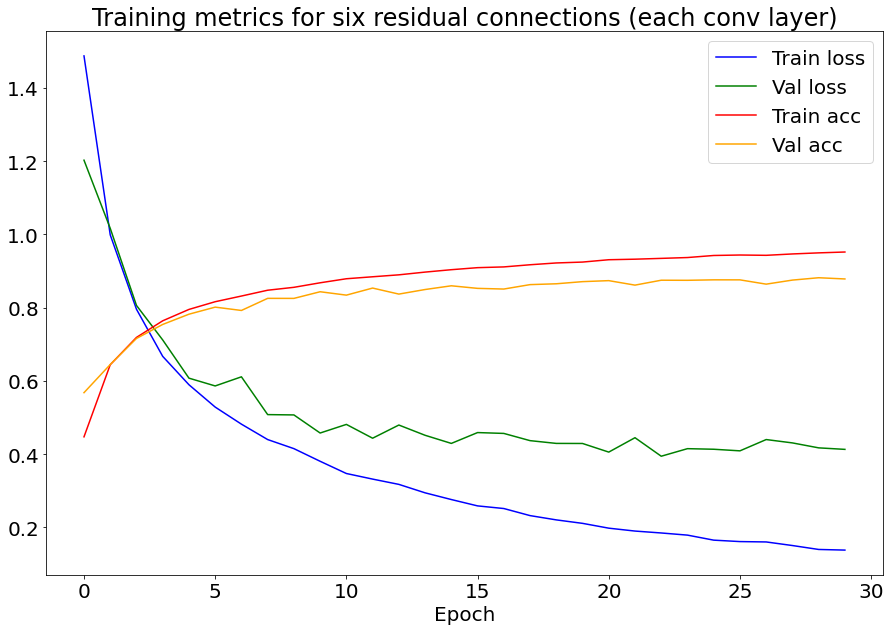

Accuracy on test set: 0.908203125


In [122]:
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(15,10))
plt.title("Training metrics for six residual connections (each conv layer)")
plt.plot(train_losses,label='Train loss',c='blue')
plt.plot(val_losses,label='Val loss',c='green')
plt.plot(train_accs,label='Train acc',c='red')
plt.plot(val_accs,label='Val acc',c='orange')
plt.xlabel("Epoch")
plt.legend(loc='upper right')
# plt.savefig("loss-acc")
plt.show()

y_test, y_score, acc = eval_model(model,test_loader)
print("Accuracy on test set:",acc)